# Electricity_Forecasting
參考文件: https://docs.google.com/document/d/11G_SqvtPEQD4cqCEfBCpBS4L8BeiVIwlNoXYy7oSdKM/edit  

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

## 整理　dataset

In [2]:
'''load data'''
path_file = '台灣電力公司_過去電力供需資訊2021.csv'
past_data = pd.read_csv(path_file)
past_data = pd.DataFrame(past_data)
past_data = past_data.loc[:,['日期','備轉容量(MW)']]
past_data.columns=['date','capacity']
past_data['date']= pd.to_datetime(past_data['date'])

# change datetime format
for index in range(len(past_data['date'])):
    index_time = str(past_data['date'][index]).split('.')[-1][1:]
    # print(index_time)
    time_change = datetime.strptime(index_time,"%Y%m%d")
    past_data['date'][index] = time_change
    past_data['capacity'][index] /= 10 

past_data['year']= pd.DatetimeIndex(past_data['date']).year
past_data['month']= pd.DatetimeIndex(past_data['date']).month
past_data['day']= pd.DatetimeIndex(past_data['date']).day
past_data['day_of_week'] = past_data['date'].dt.dayofweek

today_file =  '台灣電力公司_本年度每日尖峰備轉容量率.csv'
today_data = pd.read_csv(today_file)
today_data = pd.DataFrame(today_data)
today_data = today_data.loc[:,['date','capacity']]
today_data['date'] = pd.to_datetime(today_data['date'])
today_data['year']= pd.DatetimeIndex(today_data['date']).year
today_data['month']= pd.DatetimeIndex(today_data['date']).month
today_data['day']= pd.DatetimeIndex(today_data['date']).day
today_data['day_of_week'] = today_data['date'].dt.dayofweek

'''concat two files'''
data_cat = pd.concat([past_data[:365],today_data])

'''split training set and testing set'''
train = data_cat[:-15]
test = data_cat[-15:]

# train.set_index('date',inplace=True)
# test.set_index('date',inplace=True)
# print("train:\n",train)
# print("test:\n",test)

<AxesSubplot:xlabel='date'>

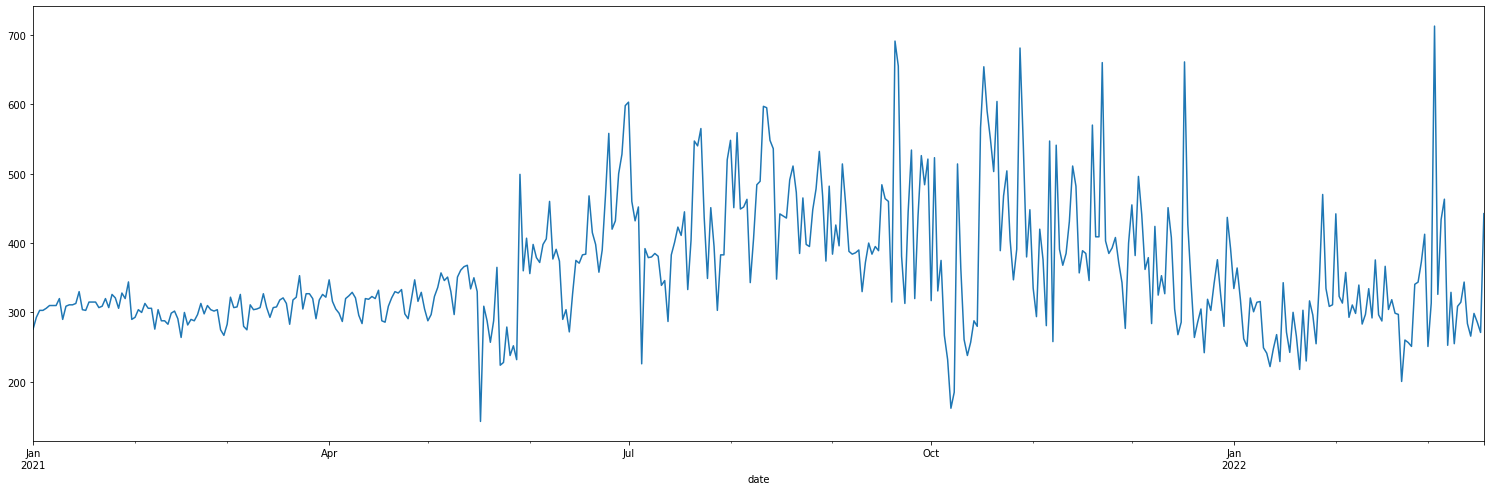

In [3]:
data_cat.set_index('date',inplace=True)
data_cat.head()
data_cat['capacity'].plot(label='first_data', figsize=(26,8))
# data_cat = data_cat.reset_index(level=0)

## xgtboost 演算法

### 使用當天的日期、前7天的 capacity

In [4]:
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

In [5]:
train.tail()

,date,capacity,year,month,day,day_of_week
57,2022-02-27,373.0,2022,2,27,6
58,2022-02-28,412.7,2022,2,28,0
59,2022-03-01,251.0,2022,3,1,1
60,2022-03-02,313.5,2022,3,2,2
61,2022-03-03,712.6,2022,3,3,3


#### train xgtboost
1. prepare data
2. fit 

In [7]:
capacity_mean = round(float(train['capacity'].mean()),1)
X_train_list = []
Y_train_list = []
for i in range(len(train['date'])):
  X = []
  Y = []
  # add today info
  X.extend([train.iloc[i]['year'],train.iloc[i]['month'],train.iloc[i]['day'],train.iloc[i]['day_of_week']])
  # add last 7 days capacity
  for last_day_index in range(1,8):
    last_day = i - last_day_index 
    if last_day >= 0:
      X.append(train.iloc[last_day]['capacity'])
    else:
      X.append(capacity_mean)
  # add today capacity for verify
  Y.append(train.iloc[i]['capacity'])
  X_train_list.append(X)
  Y_train_list.append(Y)
# change list to np-array
X_train_list = np.array(X_train_list)
Y_train_list = np.array(Y_train_list)

In [16]:
xgb_model.fit(X_train_list, Y_train_list)

[20:06:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [9]:
y_train_pred = xgb_model.predict(X_train_list)
print(len(y_train_pred))
mse=mean_squared_error(Y_train_list, y_train_pred)
print('train',np.sqrt(mse))

427
train 0.21838182599360423


In [10]:
result_df = train[['date','capacity']]
result_df['capacity_predict'] = y_train_pred
result_df.head()

,date,capacity,capacity_predict
0,2021-01-01,276.0,276.484100
1,2021-01-02,293.0,292.828491
2,2021-01-03,303.0,303.049896
3,2021-01-04,303.0,302.973602
4,2021-01-05,306.0,305.605621


In [12]:
result_df.set_index('date',inplace=True)
result_df.head()

,capacity,capacity_predict
date,,
2021-01-01,276.0,276.484100
2021-01-02,293.0,292.828491
2021-01-03,303.0,303.049896
2021-01-04,303.0,302.973602
2021-01-05,306.0,305.605621


<AxesSubplot:xlabel='date'>

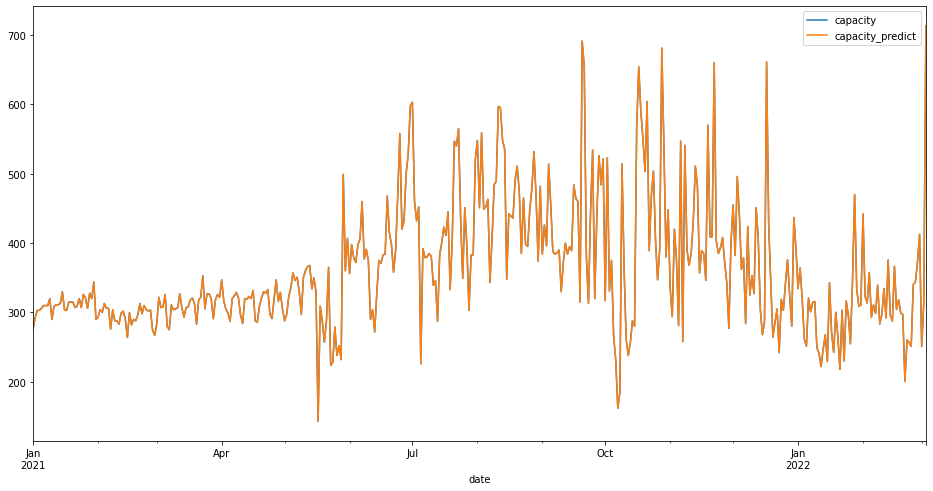

In [13]:
result_df.plot(label='first_data', figsize=(16,8))

In [14]:
result_df = result_df.reset_index(level=0)
result_df.head()

,date,capacity,capacity_predict
0,2021-01-01,276.0,276.484100
1,2021-01-02,293.0,292.828491
2,2021-01-03,303.0,303.049896
3,2021-01-04,303.0,302.973602
4,2021-01-05,306.0,305.605621


#### test xgtboost

In [17]:
Y_test_list =[]
y_test_pred_list =[]
capacity_mean = round(float(train['capacity'].mean()),1)

for i in range(len(test['date'])):
  # 一次只測試一個值(一天) 
  X_test_list =[]
  X = []
  Y = []
  # add today info
  X.extend([test.iloc[i]['year'],test.iloc[i]['month'],test.iloc[i]['day'],test.iloc[i]['day_of_week']])

  # add last 7 days info
  for last_day_index in range(1,8):
    last_day = i - last_day_index
    # if not in given data, used predicted data
    if last_day >= 0:
      X.append(y_test_pred_list[last_day])
    # if in given data, take in from training data list
    else:
      X.append(train.iloc[-last_day]['capacity'])
  # save the correct answer for later check
  Y.append(test.iloc[i]['capacity'])
  X_test_list.append(X)
  Y_test_list.append(Y)
  # predict the result, and add it to y_test_pred_list
  # it will be used right away
  y_test_pred = xgb_model.predict(X_test_list)
  y_test_pred_list.append(round(y_test_pred[0],1))

# change list to np array
X_test_list = np.array(X_test_list)
Y_test_list = np.array(Y_test_list)

In [18]:
# test the result
print(len(y_test_pred_list))
mse=mean_squared_error(Y_test_list, y_test_pred_list)
print('test',np.sqrt(mse))

15
test 69.33672609293373


In [19]:
test_result_df = test[['date','capacity']]
test_result_df['capacity_predict'] = y_test_pred_list
test_result_df.head()

,date,capacity,capacity_predict
62,2022-03-04,326.1,305.500000
63,2022-03-05,433.8,302.500000
64,2022-03-06,463.2,310.000000
65,2022-03-07,252.7,304.500000
66,2022-03-08,329.0,300.399994


<AxesSubplot:xlabel='date'>

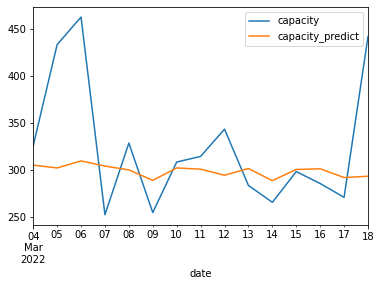

In [20]:
test_result_df.set_index('date',inplace=True)
test_result_df.plot(label='test_data') # , figsize=(16,8)

### 只用 當天日期


In [21]:
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

In [22]:
train.tail()

,date,capacity,year,month,day,day_of_week
57,2022-02-27,373.0,2022,2,27,6
58,2022-02-28,412.7,2022,2,28,0
59,2022-03-01,251.0,2022,3,1,1
60,2022-03-02,313.5,2022,3,2,2
61,2022-03-03,712.6,2022,3,3,3


#### train the xgb boost model

In [23]:
X_train_list =[]
Y_train_list =[]
for i in range(len(train['date'])):
  X = []
  Y = []
  # only add today info
  X.extend([train.iloc[i]['year'],train.iloc[i]['month'],train.iloc[i]['day'],train.iloc[i]['day_of_week']])
  # save the correct answer 
  Y.append(train.iloc[i]['capacity'])
  X_train_list.append(X)
  Y_train_list.append(Y)
# change list to np array
X_train_list = np.array(X_train_list)
Y_train_list = np.array(Y_train_list)

In [24]:
xgb_model.fit(X_train_list, Y_train_list)

[20:17:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [25]:
y_train_pred = xgb_model.predict(X_train_list)
print(len(y_train_pred))
mse=mean_squared_error(Y_train_list, y_train_pred)
print('train',np.sqrt(mse))

427
train 2.467582567309739


In [26]:
result_df = train[['date','capacity']]
result_df['capacity_predict'] = y_train_pred
result_df.head()

,date,capacity,capacity_predict
0,2021-01-01,276.0,276.996185
1,2021-01-02,293.0,293.202393
2,2021-01-03,303.0,301.947052
3,2021-01-04,303.0,303.355591
4,2021-01-05,306.0,305.223450


In [27]:
result_df.set_index('date',inplace=True)

In [28]:
result_df.head()

,capacity,capacity_predict
date,,
2021-01-01,276.0,276.996185
2021-01-02,293.0,293.202393
2021-01-03,303.0,301.947052
2021-01-04,303.0,303.355591
2021-01-05,306.0,305.223450


<AxesSubplot:xlabel='date'>

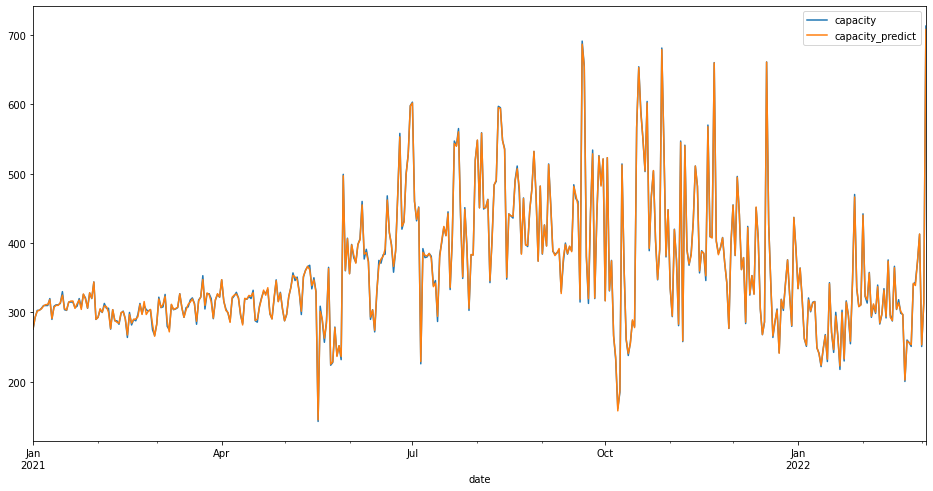

In [29]:
result_df.plot(label='first_data', figsize=(16,8))

In [30]:
result_df = result_df.reset_index(level=0)
result_df.head()

,date,capacity,capacity_predict
0,2021-01-01,276.0,276.996185
1,2021-01-02,293.0,293.202393
2,2021-01-03,303.0,301.947052
3,2021-01-04,303.0,303.355591
4,2021-01-05,306.0,305.223450


#### test the xgb boost model

In [32]:
X_test_list =[]
Y_test_list =[]

for i in range(len(test['date'])):
  X = []
  Y = []
  # only today info
  X.extend([test.iloc[i]['year'],test.iloc[i]['month'],test.iloc[i]['day'],test.iloc[i]['day_of_week']])
  # save correct answer for check
  Y.append(test.iloc[i]['capacity'])
  X_test_list.append(X)
  Y_test_list.append(Y)
X_test_list = np.array(X_test_list)
Y_test_list = np.array(Y_test_list)

In [33]:
y_test_pred = xgb_model.predict(X_test_list)
print(len(y_test_pred))
mse=mean_squared_error(Y_test_list, y_test_pred)
print('test',np.sqrt(mse))

15
test 83.74002174866352


In [34]:
test_result_df = test[['date','capacity']]
test_result_df['capacity_predict'] = y_test_pred
test_result_df.head()

,date,capacity,capacity_predict
62,2022-03-04,326.1,497.660065
63,2022-03-05,433.8,304.557465
64,2022-03-06,463.2,306.874847
65,2022-03-07,252.7,302.557526
66,2022-03-08,329.0,331.816803


<AxesSubplot:xlabel='date'>

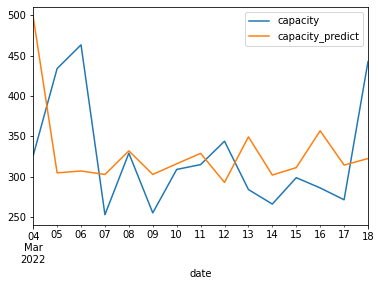

In [35]:
test_result_df.set_index('date',inplace=True)
test_result_df.plot(label='test_data') # , figsize=(16,8)

## ARIMA 整合移動平均自我迴歸模型

時間序列演算法 參考資料：https://blog.csdn.net/weixin_43861350/article/details/110008352#ARIMA__25

### 複雜版本
https://adaptable-haze-butterfly-551.medium.com/arima%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97%E6%A8%A1%E5%9E%8Bpython%E6%87%89%E7%94%A8-%E9%8A%85%E5%83%B9%E6%A0%BC%E9%A0%90%E6%B8%AC-%E4%B8%80-4f91693e3ec6  

#### ETS Decomposition Models(error-trend-seasonality)

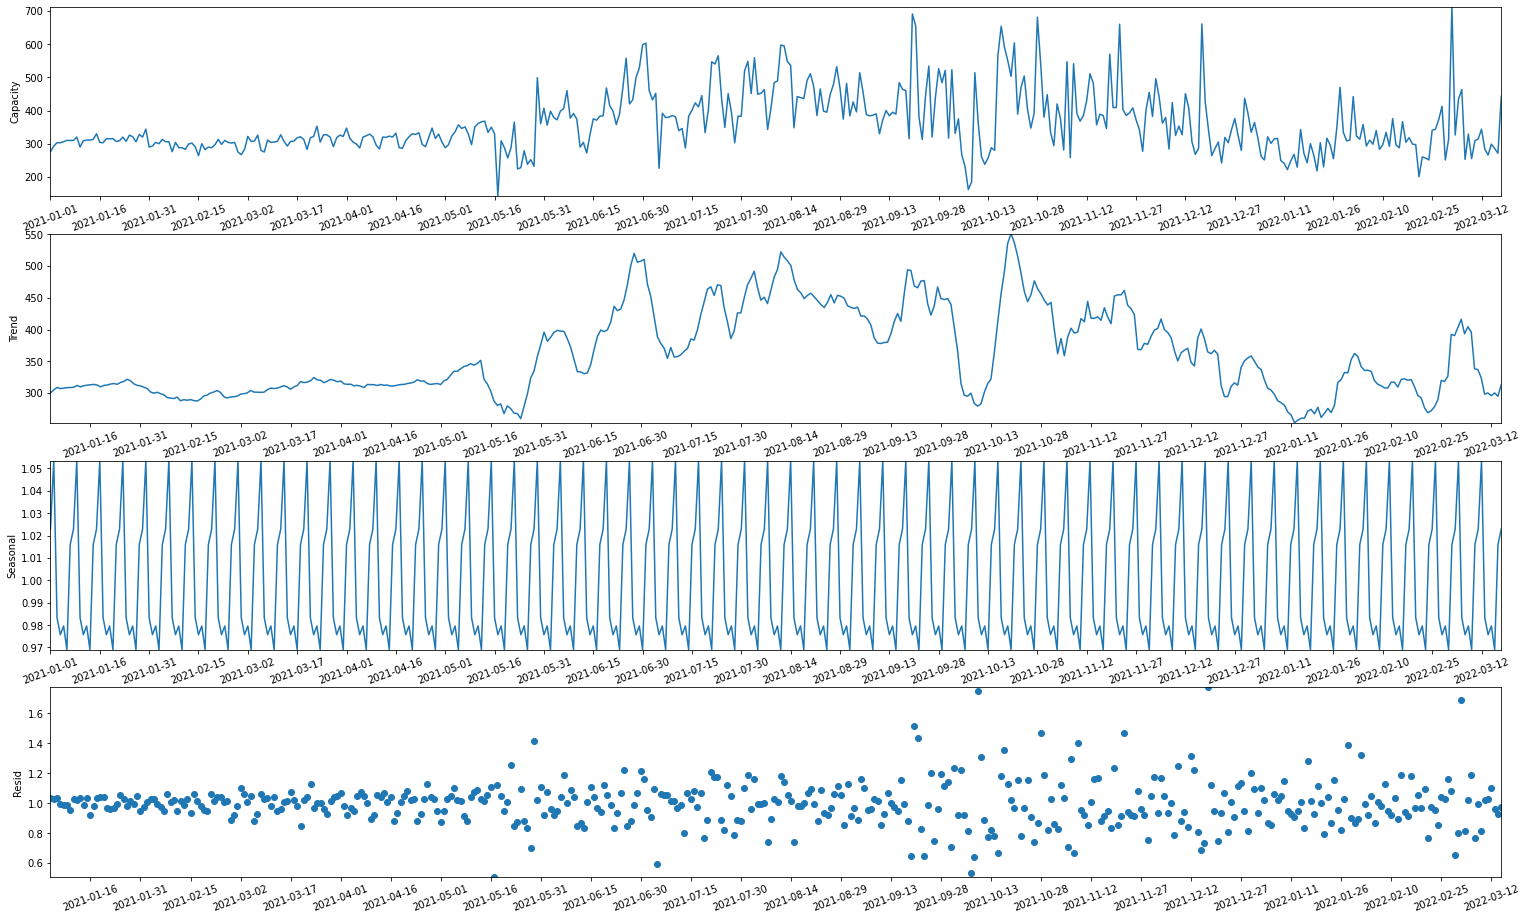

In [36]:
arima_data = data_cat['capacity']
# result = sm.tsa.seasonal_decompose(arima_data) # , freq=3
result = seasonal_decompose(arima_data, model="multiplicative") # , freq=3
plt.figure(figsize=(26,16))
plt.subplot(4,1,1)
plt.plot(result.observed, label="Copper Future")
plt.ylabel("Capacity")
plt.xticks(data_cat.index[::15], rotation=20) #調整x軸刻度的呈現(每隔12個)
plt.margins(0)

plt.subplot(4,1,2)
plt.plot(result.trend)
plt.ylabel("Trend")
plt.xticks(data_cat.index[::15], rotation=20)
plt.margins(0)

plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.ylabel("Seasonal")
plt.xticks(data_cat.index[::15], rotation=20)
plt.margins(0)

plt.subplot(4,1,4)
plt.scatter(data_cat.index,result.resid)
plt.ylabel("Resid")
plt.xticks(data_cat.index[::15], rotation=20)
plt.margins(0)  #拆成四個subplot以利調整圖片間距、x軸刻度的呈現

#### 平穩性檢驗

In [37]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test\n================================================")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value
    print(dfoutput)
    print("================================================")  
    #寫個自動判斷式
    if dfoutput[0] < dfoutput[4]:
        print("The data is stationary. (Criterical Value 1%)")  
    elif dfoutput[0] < dfoutput[5]:
        print("The data is stationary. (Criterical Value 5%)") 
    elif dfoutput[0] < dfoutput[6]:
        print("The data is stationary. (Criterical Value 10%)")
    else:
        print("The data is non-stationary, so do differencing!")
adf_test(arima_data)

Results of Dickey-Fuller Test
Test Statistic                  -2.184327
p-value                          0.211983
#Lags Used                      18.000000
Number of Observations Used    423.000000
Criterical Value (1%)           -3.445904
Criterical Value (5%)           -2.868397
Criterical Value (10%)          -2.570423
dtype: float64
The data is non-stationary, so do differencing!


Results of Dickey-Fuller Test
Test Statistic                -8.425181e+00
p-value                        1.935503e-13
#Lags Used                     1.700000e+01
Number of Observations Used    4.230000e+02
Criterical Value (1%)         -3.445904e+00
Criterical Value (5%)         -2.868397e+00
Criterical Value (10%)        -2.570423e+00
dtype: float64
The data is stationary. (Criterical Value 1%)


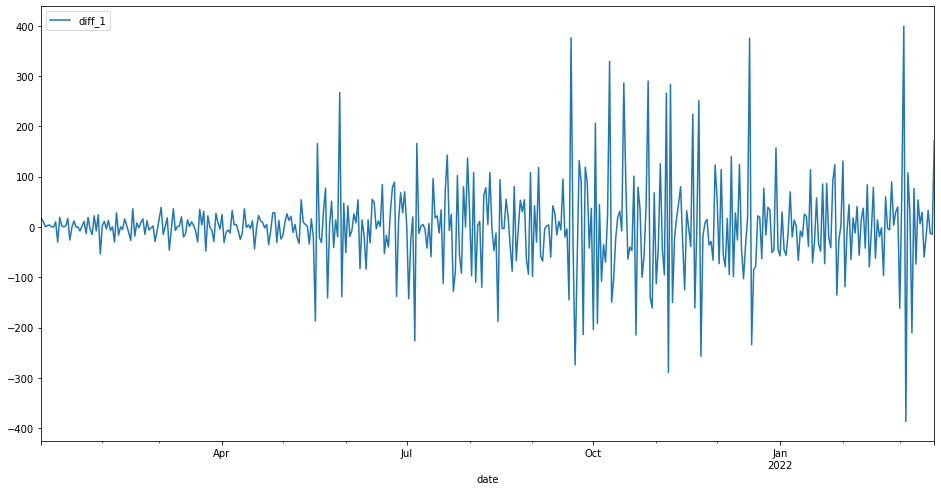

In [38]:
#一階差分 lags:1,12
diff_1 = arima_data - arima_data.shift(1) 
diff_1 = diff_1.dropna()
diff_1.head()
diff_1.plot(figsize=(16,8), label="diff_1")
plt.legend()

adf_test(diff_1)

#### 畫ACF圖與PACF圖
幫助我們判斷模型ARIMA(p, d, q)參數的選擇

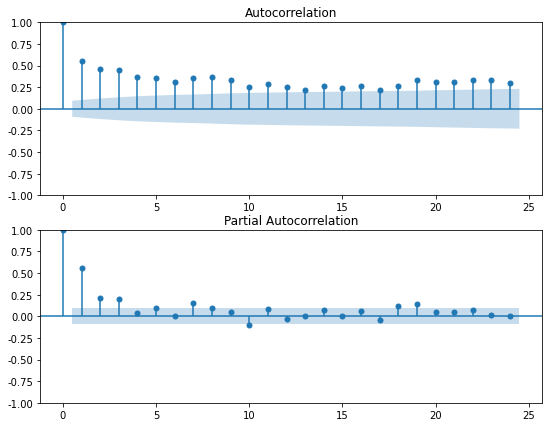

In [39]:
#correlogram
f = plt.figure(facecolor='white', figsize=(9,7))
ax1 = f.add_subplot(211)
plot_acf(arima_data, lags=24, ax=ax1)
ax2 = f.add_subplot(212)
plot_pacf(arima_data, lags=24, ax=ax2)
plt.rcParams['axes.unicode_minus'] = False 
plt.show()

ARIMA(0,1,0):AIC=5183.084689761803
ARIMA(0,1,1):AIC=5050.484532209941
ARIMA(0,1,2):AIC=5036.577844779231
ARIMA(1,1,0):AIC=5114.876219328308
ARIMA(1,1,1):AIC=5032.133618106603
ARIMA(1,1,2):AIC=5030.501754508912
ARIMA(2,1,0):AIC=5076.46093045364
ARIMA(2,1,1):AIC=5032.128147665139
ARIMA(2,1,2):AIC=5032.968413715328
ARIMA(3,1,0):AIC=5072.596768018546
ARIMA(3,1,1):AIC=5029.774176439656
ARIMA(3,1,2):AIC=5027.398539569692
This best model is ARIMA(3,1,2) based on argmin AIC.


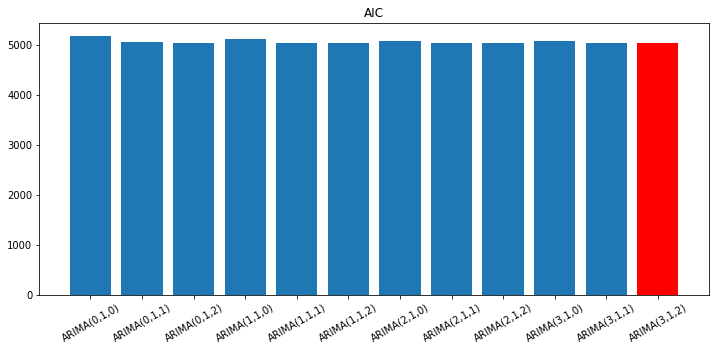

In [40]:
def arima_AIC(data, p=4, d=3, q=4):
    best_AIC =["pdq",10000]
    L =len(data)
    AIC = []
    name = []
    for i in range(p):
        for j in range(1,d):
            for k in range(q):            
                model = ARIMA(data, order=(i,j,k))
                fitted = model.fit() #disp=-1
                AIC.append(fitted.aic)
                name.append(f"ARIMA({i},{j},{k})")
                print(f"ARIMA({i},{j},{k}):AIC={fitted.aic}")
                if fitted.aic < best_AIC[1]:
                    best_AIC[0] = f"ARIMA({i},{j},{k})"
                    best_AIC[1] = fitted.aic
    print("==========================================================================")
    print(f"This best model is {best_AIC[0]} based on argmin AIC.")
    plt.figure(figsize=(12,5))
    plt.bar(name, AIC)
    plt.bar(best_AIC[0], best_AIC[1], color = "red")
    plt.xticks(rotation=30)
    plt.title("AIC")
    plt.show()
arima_AIC(arima_data, 4,2,3)

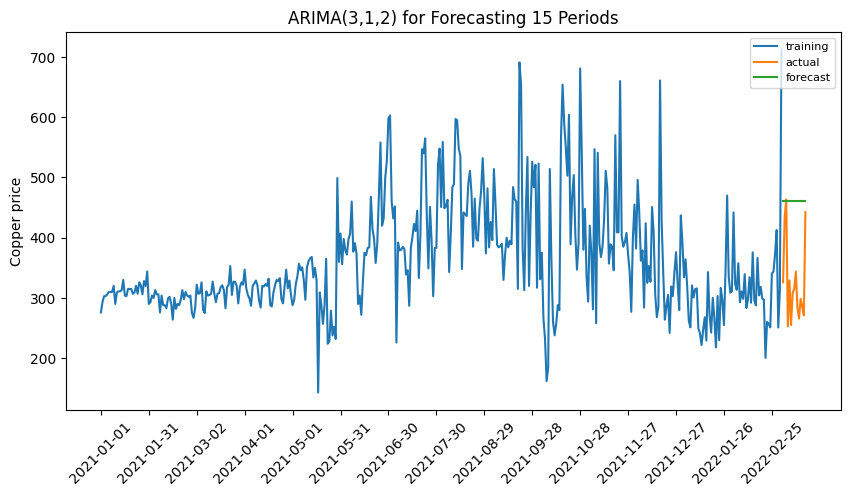

Mean Absolute Error : 135.58163508585238
Mean Squared Error : 22665.993842287713
fc_series: date
2022-03-04    460.186502
2022-03-05    460.186502
2022-03-06    460.186502
2022-03-07    460.186502
2022-03-08    460.186502
2022-03-09    460.186502
2022-03-10    460.186502
2022-03-11    460.186502
2022-03-12    460.186502
2022-03-13    460.186502
2022-03-14    460.186502
2022-03-15    460.186502
2022-03-16    460.186502
2022-03-17    460.186502
2022-03-18    460.186502
dtype: float64
Copper price: date
2022-03-04    326.1
2022-03-05    433.8
2022-03-06    463.2
2022-03-07    252.7
2022-03-08    329.0
2022-03-09    255.0
2022-03-10    308.8
2022-03-11    314.8
2022-03-12    343.8
2022-03-13    283.9
2022-03-14    265.9
2022-03-15    298.6
2022-03-16    285.9
2022-03-17    271.2
2022-03-18    442.4
Name: capacity, dtype: float64


In [42]:
#data spilt
period = 15
title = f'ARIMA(3,1,2) for Forecasting {period} Periods'
L = len(arima_data)
x_train = arima_data[:(L-period)]
x_test = arima_data[-period:]
#Build Model 
model = ARIMA(x_train, order=(3, 1, 2)) 
fitted = model.fit()# disp=-1
#Forecast
fc, se, conf,_,_,_,_,_,_,_,_,_,_,_,_ = fitted.forecast(period, alpha=0.05) # 95% conf
#Make as pandas series
fc_series = pd.Series(fc, index=x_test.index)
#Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(x_train, label='training')
plt.plot(x_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.xticks(data_cat.index[::30], rotation=45)
plt.title(title)
plt.ylabel("Copper price")
plt.legend(loc='upper right', fontsize=8)
plt.show()
#Results
print(f"Mean Absolute Error : {mean_absolute_error(fc_series,x_test)}")
print(f"Mean Squared Error : {mean_squared_error(fc_series,x_test)}")
print("===========================") 
print("fc_series:",fc_series)
print("===========================")
print("Copper price:",x_test)

### 簡易版 ARIMA 試驗
參考資料:  
- https://www.itread01.com/content/1544268486.html
- https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [44]:
arima_data = data_cat['capacity']
arima_data.head()

date
2021-01-01    276.0
2021-01-02    293.0
2021-01-03    303.0
2021-01-04    303.0
2021-01-05    306.0
Name: capacity, dtype: float64

#### 只使用原始資料

In [56]:
test_count = 14

In [58]:
def predict(data,test_count):
	train, test = data[0:-test_count], data[-test_count:]
	# all the history data
	history = [x for x in train]
	predictions = []
	for t in range(test_count):
		# get the model from history data
		model = ARIMA(history, order=(3,1,2))
		# predict today capacity
		model_fit = model.fit()
		output = model_fit.forecast()
		yhat = output[0]
		# save result to predictions for later check correctness
		predictions.append(yhat)
		# save result to history for next day capacity prediction
		history.append(yhat)

		##  save predicted info to a new row in train dataframe
		# someday = train[-1:].index.values[0]
		# someday= pd.to_datetime(someday,format = '%Y-%m-%d %H:%M:%S')
		# onemore_date = someday + timedelta(days=1)
		# train.loc[onemore_date] = [round(yhat,1)]
		# print('predicted=%f, expected=%f' % (yhat, test[t]))

	predictions_df = pd.DataFrame(predictions,columns=['predicted_capacity'])
	# calculate the error by mse
	error = mean_squared_error(test, predictions_df)
	print('Test MSE: %.3f' % error)

	# combine the correct answer (in test), and predicted answer (in predictions_df) 
	# to result
	test = test.reset_index(level=0)
	result = pd.concat([test,predictions_df],axis=1)

	return result

Test MSE: 3941.234


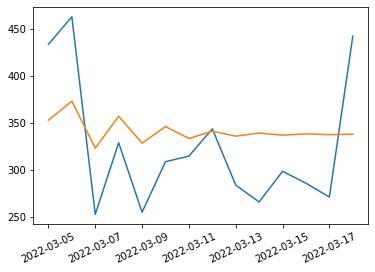

In [59]:
result = predict(arima_data,test_count)
result = result.set_index('date')
result.head()
plt.xticks(rotation=25)
plt.plot(result)

#### 先使用一階差分

In [60]:
test_count = 14

In [61]:
def diff_predict(data,test_count):
    #一階差分 lags:1,12
    diff_1 = data.diff()
    diff_1 = diff_1.dropna()
    # all the history data after diff
    train, test = diff_1[0:-test_count], diff_1[-test_count:]
    history = [x for x in train]
    predictions = []

    for t in range(test_count):
        # get the model from history data
        model = ARIMA(history, order=(3,1,2))
        # predict the result (diff)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        # save result to predictions for later check correctness
        predictions.append(yhat)
        # save result to history for next day capacity diff prediction
        history.append(yhat)

        # # save predicted info to a new row in train dataframe
        # someday = train[-1:].index.values[0]
        # someday= pd.to_datetime(someday,format = '%Y-%m-%d %H:%M:%S')
        # onemore_date = someday + timedelta(days=1)
        # train.loc[onemore_date] = [round(yhat,1)]
        # print('predicted=%f, expected=%f' % (yhat, test[t]))

    # change diff to real capacity (need last capacity to calculate)
    predictions_df = pd.DataFrame(predictions,columns=['predicted_capacity'])
    ## first one need training dataset last one to calculate
    predictions_df.iloc[0]['predicted_capacity'] = predictions_df.iloc[0]['predicted_capacity'] + data[-len(test)-1]
    ## second and so on need front predicted_capacity
    for t in range(1,len(test)):
        predictions_df.iloc[t]['predicted_capacity'] = predictions_df.iloc[t-1]['predicted_capacity'] + predictions_df.iloc[t]['predicted_capacity']

    # save real capacity to real_test 
    # for later check correctness
    real_test = data[-len(test):]
    error = mean_squared_error(real_test, predictions_df)
    print('Test MSE: %.3f' % error)
    real_test = real_test.reset_index(level=0)

    # combine the correct answer (in real_test), and predicted answer (in predictions_df) 
	# to result
    result = pd.concat([real_test,predictions_df],axis=1)
    
    return result

In [62]:
arima_data.tail()

date
2022-03-14    265.9
2022-03-15    298.6
2022-03-16    285.9
2022-03-17    271.2
2022-03-18    442.4
Name: capacity, dtype: float64

Test MSE: 15624.502


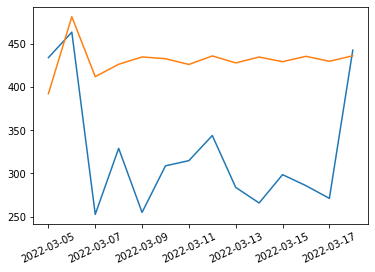

In [63]:
result = diff_predict(arima_data,test_count)
result = result.set_index('date')
result.head()
plt.xticks(rotation=25)
plt.plot(result)

In [64]:
result.tail()

,capacity,predicted_capacity
date,,
2022-03-14,265.9,434.510548
2022-03-15,298.6,429.088141
2022-03-16,285.9,435.302870
2022-03-17,271.2,429.577716
2022-03-18,442.4,435.933995


## SARIMA 模型
